In [2]:
# Import necessary libraries for PyTorch, dataset handling, and visualization
import torch
print(torch.cuda.is_available())  # # Check if CUDA (GPU support) is available / Should print True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn # Neural network layers
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm # Progress bar for training loops
import torchvision.datasets as dsets
import torchvision.transforms as transforms # Image transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from torchsummary import summary

True


In [3]:
# Set hyperparameters
Batch_Size = 100               # Number of samples per training batch
Num_Epoch = 2                  # num of training epochs
Learning_Rate = 0.01          # Learning rate for optimizer
Criterion = nn.CrossEntropyLoss()  # Standard classification loss function
Optimizer = torch.optim.Adam       # Optimizer (we'll use SGD later in `fit()`) (Used elsewhere for flexibility)

In [4]:
Train_dataset=dsets.CIFAR10(root='./data',train=True,transform=transforms.ToTensor(),download=True)
Test_dataset=dsets.CIFAR10(root='./data',train=False,transform=transforms.ToTensor(),download=True)

Train_loader=DataLoader(dataset=Train_dataset,batch_size=Batch_Size,shuffle=True)
Test_loader=DataLoader(dataset=Test_dataset,batch_size=Batch_Size,shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [5]:
# Print class names to index mapping
class_to_index = Train_dataset.class_to_idx
print(class_to_index)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


2
(32, 32, 3)


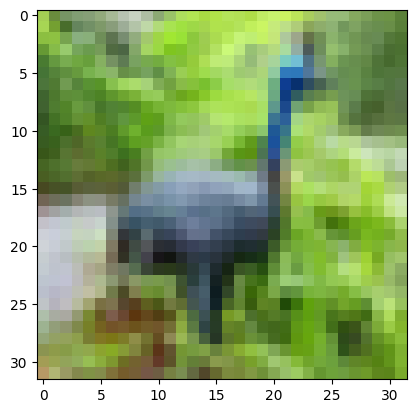

In [6]:
# Visualize one example image from dataset
index = 6
print(Train_dataset.targets[index])
print(Train_dataset.data[index].shape) # Image shape (32x32x3)
plt.imshow(Train_dataset.data[index])

In [7]:
# Training function (single epoch)

# This function performs a single epoch of training.
# It loops over the entire training dataset, does forward propagation, computes loss,
# and performs backpropagation to update model parameters using the specified optimizer.

def fit(model, Train_loader):
  model.train()
  device = next(model.parameters()).device.index
  optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9) # Use SGD optimizer with momentum

  losses = []
  for i, data in enumerate(Train_loader):
    image = data[0].type(torch.FloatTensor).cuda() # Move image batch to GPU
    label = data[1].type(torch.LongTensor).cuda()

    pred_label = model(image)  # Forward pass
    loss = Criterion(pred_label, label)   # Compute loss
    losses.append(loss.item())  # Save loss

    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update model weights


  avg_loss = sum(losses)/len(losses)  # Compute average loss for this epoch
  return avg_loss

In [27]:
# Evaluation function (returns accuracy only)
# This function evaluates the model on the test set.
# It disables gradient calculation for efficiency and computes the accuracy of predictions.

def eval(model, Test_loader):
    model.eval()   # Set model to evaluation mode
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(Test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        real_labels += list(label.cpu().detach().numpy())  # Store ground truth
        pred = model(image)  # Forward pass
        pred = list(pred.cpu().detach().numpy())  # Store predictions (as numpy arrays)
        pred_labels += pred

    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = np.argmax(pred_labels, axis=1) # Convert logits to predicted class

    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(real_labels, pred_labels)
    return accuracy


In [9]:
# MobileNetV2 building blocks
from torch.hub import load_state_dict_from_url # For pretrained weights

In [16]:
# MobileNetV2 Basic Block - ConvBNReLU

# This is a basic building block that combines a Conv2D layer, BatchNorm2D, and ReLU6 activation.
# This combo is commonly used in CNNs and is designed for efficient computation in mobile devices.
# ReLU6 limits activation to [0, 6], which helps in quantized or low-precision computing environments.

# This block performs Convolution -> BatchNorm -> ReLU6

class ConvBNReLU(nn.Sequential):
  def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, bn_aff=True):
    padding = (kernel_size -1 )//2   # Same padding to maintain spatial dimensions
    super(ConvBNReLU, self).__init__(
        nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),  # Main convolution
        nn.BatchNorm2d(out_planes, affine=bn_aff),  # Normalize
        nn.ReLU6(inplace=True)    # Mobile-friendly activation with capped max = 6
        )

In [22]:
# MobileNetV2 Core Block - Inverted Residual

# This is the core block used in MobileNetV2
# It includes an expansion layer, a depthwise separable convolution, and a projection layer.
# A residual (shortcut) connection is added when input and output shapes match.

class invertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, shortcut, bn_aff):
        super(invertedResidual, self).__init__()
        self.shortcut = shortcut   # Whether to use residual connection
        self.bn_aff = bn_aff
        self.stride = stride
        assert stride in [1, 2]  # Only allowed strides

        hidden_dim = int(round(inp * expand_ratio))   # # Expanded hidden dimension
        self.use_res_connect = self.stride == 1 and inp == oup   # Residual if size matches

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, bn_aff=self.bn_aff)) # Expand channels

        # Depthwise convolution: very efficient, applied per channel
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, bn_aff=self.bn_aff),
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),  # Project back to output channels
            nn.BatchNorm2d(oup, affine=self.bn_aff)  # Normalize output
        ])
        self.conv = nn.Sequential(*layers)  # Combine all layers sequentially


    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x) if self.shortcut else self.conv(x)  # Residual connection if applicable
        else:
            return self.conv(x)  # No shortcut

In [29]:
model_urls = {'MobileNetV2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'}

# Helper function to round channel numbers
# Ensures the number of channels is divisible by 8.
# This improves memory alignment and computational efficiency on GPUs and mobile devices.

def _make_divisible(x, divisible_by=8):
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


# Full MobileNetV2 Model
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0, round_nearest=8, block=None, shortcut=True, bn_aff=True):
        super(MobileNetV2, self).__init__()
        if block is None:
            block = invertedResidual  # Default block
        input_channel = 32
        last_channel = 1280  # Final projection before FC layer
        self.bn_aff = bn_aff
        self.shortcut = shortcut

        # Config: t, c, n, s (expansion ratio, output channels, number of blocks, stride)
        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)

        features = [ConvBNReLU(3, input_channel, stride=2, bn_aff=self.bn_aff)]  # Initial convolution

        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)

            for i in range(n):
                stride = s if i == 0 else 1  # Apply stride only once per stage
                features.append(block(input_channel, output_channel, stride, t, shortcut, bn_aff))
                input_channel = output_channel

        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, bn_aff=self.bn_aff))  # Final 1x1 conv
        self.features = nn.Sequential(*features)  # Feature extractor
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(self.last_channel, num_classes))  # Final classifier

        self._initialize_weights()  # Initialize all layers


    def forward(self, x):
        x = self.features(x)  # Pass through conv blocks
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)  # Global avg pooling
        x = self.classifier(x)  # Final FC layer
        return x



# Weight Initialization
# This function initializes weights for all modules in the model
# Using Kaiming (He) initialization which works well with ReLU activation functions.
# BatchNorm layers are initialized to preserve scale and shift (gamma=1, beta=0)
# Fully connected layers are initialized with small random values for stability.

    def _initialize_weights(self):  # Kaiming initialization (best for ReLU)

        for m in self.modules():

            if isinstance(m, nn.Conv2d):  # For all convolutional layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out')  # Kaiming normal init

                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Zero bias

            elif isinstance(m, nn.BatchNorm2d):  # For batch norm layers
                nn.init.ones_(m.weight)  # Set gamma to 1
                nn.init.zeros_(m.bias)  # Set beta to 0

            elif isinstance(m, nn.Linear):  # For fully connected (linear) layers
                nn.init.normal_(m.weight, 0, 0.01)  # Small random values
                nn.init.zeros_(m.bias)  # Zero bias


In [30]:
# MobileNetV2 Factory Function (builds model instance with or without pretrained weights)
# This function creates and returns a MobileNetV2 model instance.
# If 'pretrained=True' is specified, it loads the pretrained weights from the official PyTorch model hub.
# You can also pass custom keyword arguments (e.g., num_classes=10 for CIFAR-10).

def mobilenet_v2(pretrained=False, progress=True, **kwargs):
    model = MobileNetV2(**kwargs)  # Instantiate the model with passed arguments

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['MobileNetV2'], progress=progress)  # Load pretrained weights from URL
        model.load_state_dict(state_dict)  # Apply pretrained weights to the model

    return model  # Return the constructed model instance

In [31]:
# Train model using CIFAR-10
# Here we create a MobileNetV2 model specifically for CIFAR-10 (10 output classes).
# The model is then trained over several epochs, with loss and accuracy recorded after each epoch.

mobile_model = mobilenet_v2(num_classes=10).cuda()  # Instantiate and move to GPU (output layer set to 10 classes)


train_loss5 = []
test_accuracy5 = []


# This loop handles the training and evaluation for each epoch.
# It calls the 'fit()' function to train on the training dataset, and 'eval()' to compute test accuracy.
# The results are stored in train_loss5 and test_accuracy5 respectively.

for epoch in tqdm(range(Num_Epoch)): # Repeat for each epoch
    train_loss5.append(fit(mobile_model, Train_loader))
    test_accuracy5.append(eval(mobile_model, Test_loader))  # Evaluate on test set and record accuracy


100%|██████████| 2/2 [00:38<00:00, 19.17s/it]


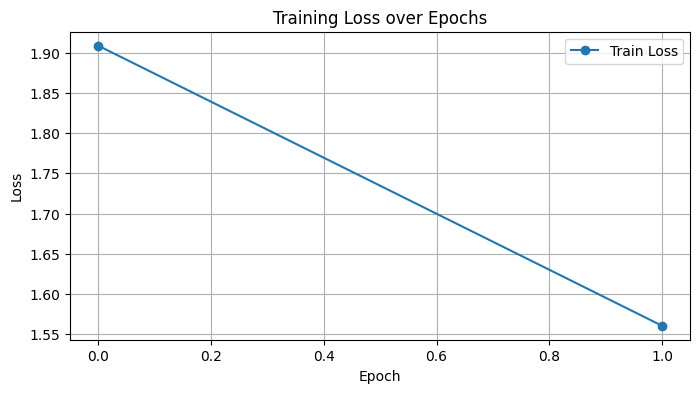

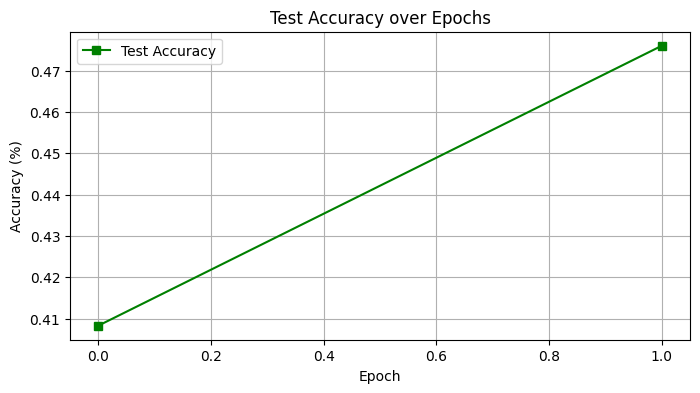

In [32]:
# Training Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(train_loss5, label='Train Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Test Accuracy Plot
plt.figure(figsize=(8, 4))
plt.plot(test_accuracy5, label='Test Accuracy', marker='s', color='green')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    device = next(model.parameters()).device.index
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda(device)
            labels = labels.cuda(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix")
    plt.show()

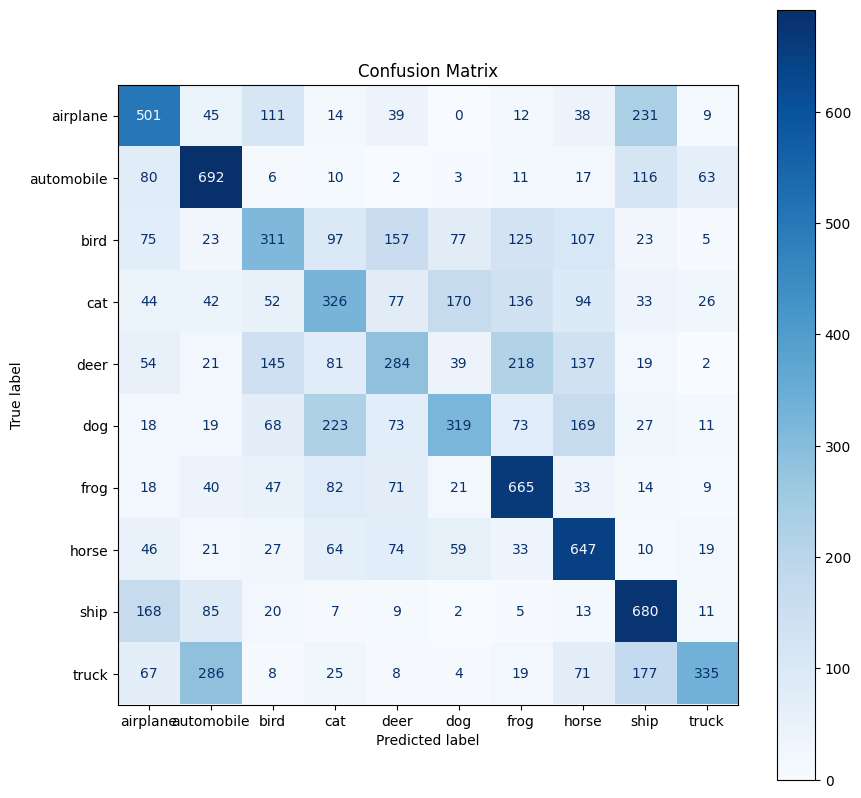

In [35]:
class_names = Train_dataset.classes  # ['airplane', 'automobile', ..., 'truck']
plot_confusion_matrix(mobile_model, Test_loader, class_names)

In [36]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_loader, class_names):
    model.eval()
    device = next(model.parameters()).device.index
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda(device)
            labels = labels.cuda(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("📋 Classification Report:\n")
    print(report)

In [37]:
class_names = Train_dataset.classes

print_classification_report(mobile_model, Test_loader, class_names)

📋 Classification Report:

              precision    recall  f1-score   support

    airplane     0.4678    0.5010    0.4838      1000
  automobile     0.5432    0.6920    0.6086      1000
        bird     0.3912    0.3110    0.3465      1000
         cat     0.3509    0.3260    0.3380      1000
        deer     0.3577    0.2840    0.3166      1000
         dog     0.4597    0.3190    0.3766      1000
        frog     0.5127    0.6650    0.5790      1000
       horse     0.4879    0.6470    0.5563      1000
        ship     0.5113    0.6800    0.5837      1000
       truck     0.6837    0.3350    0.4497      1000

    accuracy                         0.4760     10000
   macro avg     0.4766    0.4760    0.4639     10000
weighted avg     0.4766    0.4760    0.4639     10000



In [38]:
from sklearn.metrics import classification_report
import pandas as pd

def get_classification_report_df(model, test_loader, class_names):
    model.eval()
    device = next(model.parameters()).device.index
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda(device)
            labels = labels.cuda(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Get report as a dictionary
    report_dict = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        output_dict=True,
        digits=4
    )

    # Convert to pandas DataFrame
    df = pd.DataFrame(report_dict).transpose()

    return df

In [39]:
class_names = Train_dataset.classes
report_df = get_classification_report_df(mobile_model, Test_loader, class_names)

import matplotlib.pyplot as plt

# Show full dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

display(report_df.round(4))

,precision,recall,f1-score,support
airplane,0.4678,0.501,0.4838,1000.000
automobile,0.5432,0.692,0.6086,1000.000
bird,0.3912,0.311,0.3465,1000.000
cat,0.3509,0.326,0.3380,1000.000
deer,0.3577,0.284,0.3166,1000.000
dog,0.4597,0.319,0.3766,1000.000
frog,0.5127,0.665,0.5790,1000.000
horse,0.4879,0.647,0.5563,1000.000
ship,0.5113,0.680,0.5837,1000.000
truck,0.6837,0.335,0.4497,1000.000
